In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
Temperature = ctrl.Antecedent(np.arange(0, 101, 1), 'temperature')
Temperature['base'] = fuzz.trimf(Temperature.universe, [0, 0, 40])
Temperature['normale'] = fuzz.trimf(Temperature.universe, [30, 50, 70])
Temperature['elevee'] = fuzz.trimf(Temperature.universe, [60, 100, 100])

In [4]:
Vibration = ctrl.Antecedent(np.arange(0, 11, 0.1), 'vibration')
Vibration['faible'] = fuzz.trimf(Vibration.universe, [0, 0, 4])
Vibration['moyenne'] = fuzz.trimf(Vibration.universe, [2, 5, 8])
Vibration['elevee'] = fuzz.trimf(Vibration.universe, [6, 10, 10])

In [5]:
Age = ctrl.Antecedent(np.arange(0, 21, 1), 'age')
Age['neuf'] = fuzz.trimf(Age.universe, [0, 0, 7])
Age['moyen'] = fuzz.trimf(Age.universe, [5, 10, 15])
Age['ancien'] = fuzz.trimf(Age.universe, [12, 20, 20])

In [6]:
Risque_panne = ctrl.Consequent(np.arange(0, 11, 1), 'risque_panne')
Risque_panne['faible'] = fuzz.trimf(Risque_panne.universe, [0, 0, 4])
Risque_panne['moyen'] = fuzz.trimf(Risque_panne.universe, [2, 5, 8])
Risque_panne['elevee'] = fuzz.trimf(Risque_panne.universe, [6, 10, 10])

c:\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


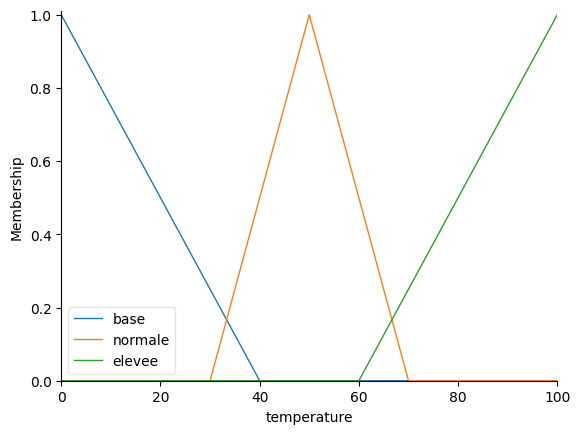

In [7]:
Temperature.view()

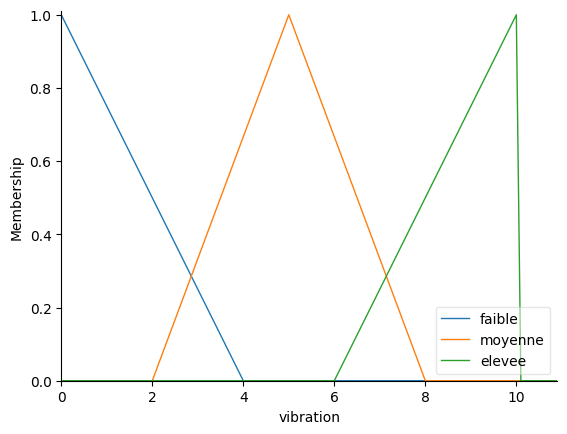

In [8]:
Vibration.view()

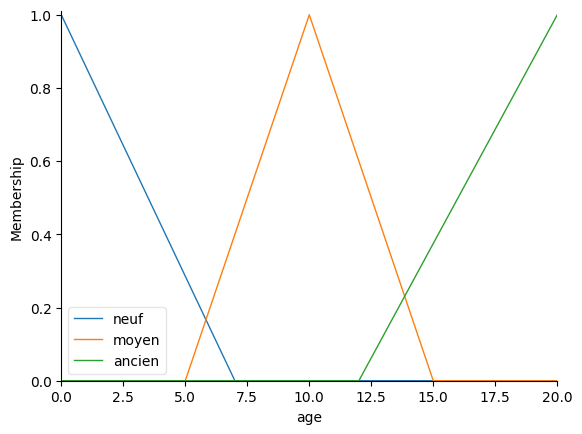

In [9]:
Age.view()

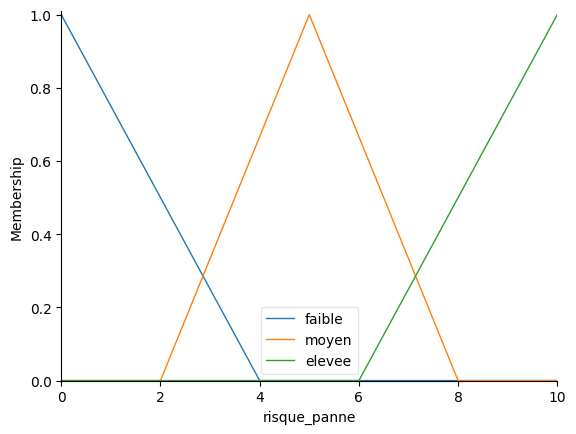

In [10]:
Risque_panne.view()

In [11]:
rule1 = ctrl.Rule(Temperature['base'] & Vibration['faible'] & Age['neuf'], Risque_panne['faible'])
rule2 = ctrl.Rule(Temperature['elevee'] & Vibration['elevee'] , Risque_panne['elevee'])
rule3 = ctrl.Rule(Age['ancien'] & Vibration['moyenne'], Risque_panne['moyen'])
rule4 = ctrl.Rule(Temperature['normale'] & Age['moyen'], Risque_panne['moyen'])

In [65]:
risque_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
risque_simulation = ctrl.ControlSystemSimulation(risque_ctrl)

In [46]:
import pandas as pd
np.random.seed(42)
n = 2000
data = pd.DataFrame({
    'Temperature': np.random.uniform(0, 100, n),
    'Vibration':   np.random.uniform(0, 10, n),
    'Age':         np.random.uniform(0, 20, n)
})
data.head()

,Temperature,Vibration,Age
0,37.454012,2.617057,11.439918
1,95.071431,2.469788,16.108647
2,73.199394,9.062546,15.203219
3,59.865848,2.495462,3.077998
4,15.601864,2.719497,2.984989


In [52]:
def fuzzy_risk(t, v, a):
    try:
        sim = ctrl.ControlSystemSimulation(risque_ctrl)
        sim.input['temperature'] = t
        sim.input['vibration'] = v
        sim.input['age'] = a
        sim.compute()
        return sim.output['risque_panne']
    except:
        return np.nan
    
fuzzy_risk(70, 8, 15)

np.float64(8.238095238095239)

In [55]:
data['risque_panne'] = data.apply(lambda r: fuzzy_risk(r['Temperature'], r['Vibration'], r['Age']), axis=1)
data.dropna(inplace=True)

In [58]:
X = data[['Temperature', 'Vibration', 'Age']]
y = data['risque_panne']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
import math
y_pred = model.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Evaluation du modele ML:")
print(f"Nombre d'echantillons: {len(data)}")
print(f"RMSE : {rmse:.3f}")
print(f"R² : {r2:.4f}\n")

📊 Évaluation du modèle ML :
Nombre d'échantillons : 1178
RMSE : 0.221
R² : 0.9874



In [ ]:
importances = pd.DataFrame({
    'Variable': ['Temperature', 'Vibration', 'Age'],
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance des variables:")
print(importances.to_string(index=False))

🔍 Importance des variables :
   Variable  Importance
Température    0.381513
  Vibration    0.363796
        Âge    0.254691


In [64]:
sample = X_test.sample(5, random_state=1)
pred = model.predict(sample)
print("Exemples predits vs realite:")
for i in range(len(sample)):
    print(f"T={sample.iloc[i,0]:.1f}, V={sample.iloc[i,1]:.1f}, Âge={sample.iloc[i,2]:.1f}  →  "
          f"Risque flou={y_test.iloc[i]:.2f}, ML={pred[i]:.2f}")

Exemples predits vs realite:
T=44.9, V=9.7, Âge=10.3  →  Risque flou=8.48, ML=5.00
T=66.4, V=7.5, Âge=7.0  →  Risque flou=8.23, ML=6.46
T=38.1, V=1.3, Âge=11.5  →  Risque flou=5.00, ML=5.00
T=27.4, V=4.4, Âge=17.4  →  Risque flou=5.00, ML=5.00
T=41.0, V=3.9, Âge=18.9  →  Risque flou=5.00, ML=5.00
